In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torchsummary import summary

from torchvision.utils import save_image
from IPython.core.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
from VAE.model import *
from VAE.data import *
from MDN_RNN.model import *

/tmp/ipykernel_133446/103143013.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import Image, display


device cuda is ready


In [3]:
z = np.load("Z.npy")
print(z.shape)
z = torch.from_numpy(z)

(16, 32, 32, 4, 4)


In [4]:
vae = VAE(32, batch_size=1).to(DEVICE)
vae.load_state_dict(torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/ROBOT.pt', weights_only=True))
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 512, kernel_size=(4, 4), 

In [5]:
z.size()

torch.Size([16, 32, 32, 4, 4])

In [6]:
z = z.view(16, -1, 512)
z.size()

torch.Size([16, 32, 512])

In [7]:
bsz = 16

In [8]:
zsize=512
nhidden=256
n_gaussians = 5

In [9]:
model = MDNRNN(zsize, nhidden).to(DEVICE)
model

MDNRNN(
  (lstm): LSTM(512, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=2560, bias=True)
  (fc2): Linear(in_features=256, out_features=2560, bias=True)
  (fc3): Linear(in_features=256, out_features=2560, bias=True)
)

In [10]:
seqlen=16

In [11]:
z.shape

torch.Size([16, 32, 512])

In [12]:
z.to(DEVICE)

tensor([[[-0.0255, -0.0285, -0.1681,  ..., -0.0667, -0.0642, -0.0913],
         [-0.0302, -0.0335, -0.1416,  ..., -0.1057, -0.0776, -0.1080],
         [-0.0314, -0.0313, -0.1384,  ..., -0.1100, -0.0873, -0.1139],
         ...,
         [-0.0468, -0.0526, -0.1490,  ..., -0.0992, -0.0199, -0.0993],
         [-0.0420, -0.0465, -0.1535,  ..., -0.0729,  0.0147, -0.0628],
         [-0.0415, -0.0329, -0.1510,  ..., -0.0629, -0.0340, -0.0507]],

        [[-0.0255, -0.0285, -0.1681,  ..., -0.0667, -0.0642, -0.0913],
         [-0.0302, -0.0335, -0.1416,  ..., -0.1057, -0.0776, -0.1080],
         [-0.0314, -0.0313, -0.1384,  ..., -0.1100, -0.0873, -0.1139],
         ...,
         [-0.0468, -0.0526, -0.1490,  ..., -0.0992, -0.0199, -0.0993],
         [-0.0420, -0.0465, -0.1535,  ..., -0.0729,  0.0147, -0.0628],
         [-0.0415, -0.0329, -0.1510,  ..., -0.0629, -0.0340, -0.0507]],

        [[-0.0255, -0.0285, -0.1681,  ..., -0.0667, -0.0642, -0.0913],
         [-0.0302, -0.0335, -0.1416,  ..., -0

In [13]:
train_RNN(epochs=500, seqlen=seqlen, model=model, z=z, bsz=bsz)

Epoch [0/500], Loss: 0.9935
Epoch [100/500], Loss: -1.8891
Epoch [200/500], Loss: -1.8475
Epoch [300/500], Loss: -2.3533
Epoch [400/500], Loss: -2.0708


In [37]:
zero = np.random.randint(z.size(0))
one = np.random.randint(z.size(1))
x = z[zero:zero+1, one:one+1, :]
y = z[zero:zero+1, one+1:one+2, :]

hidden = model.init_hidden(1)
(pi, mu, sigma), _ = model(x, hidden)

y_preds = [torch.normal(mu, sigma)[:, :, i, :] for i in range(n_gaussians)]

compare_x = vae.decode(torch.cat([x, y] + y_preds))

# compare_x = vae.decode(z_out)
save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=1000, unconfined=True))

torch.Size([1, 1, 512])


Text(0.5, 1.0, 'real next')

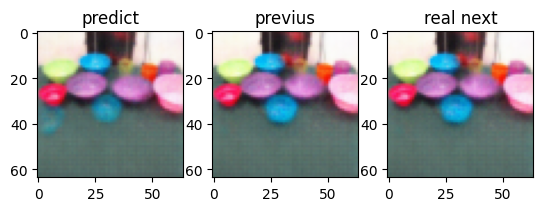

In [38]:
plt.subplot(1, 3, 1)
plt.imshow(a1[0])
plt.title("predict") 
plt.subplot(1, 3, 2)
plt.imshow(b1[0])
plt.title("previus") 
plt.subplot(1, 3, 3)
plt.imshow(c1[0])
plt.title("real next") 

# NEXT PREDICTION

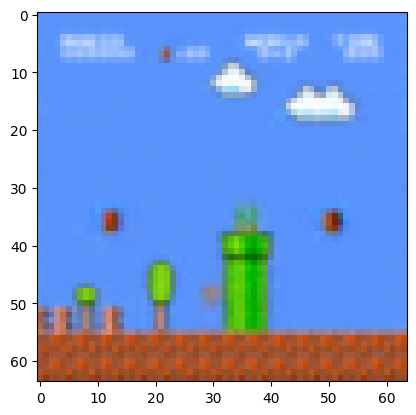

In [122]:
plt.imshow(a1[0])

# PREVIUS

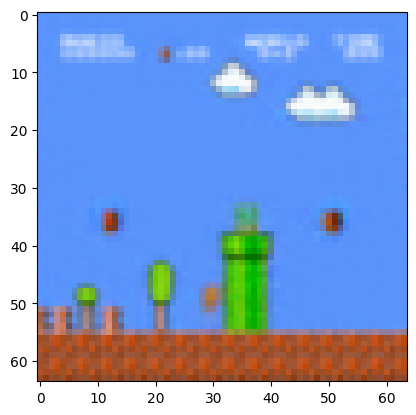

In [123]:
plt.imshow(b1[0])

# REAL NEXT CADR

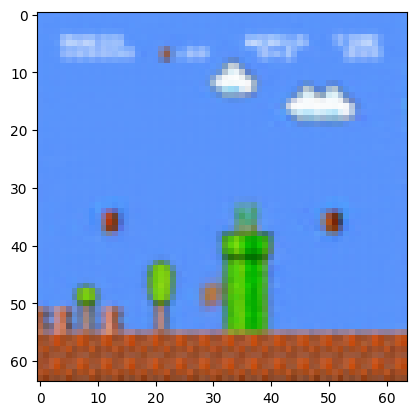

In [124]:
plt.imshow(c1[0])

In [120]:
torch.save(model, "RNN.pt")